# Get Projections

<br/>

<pre>
model name:            imagewoof_128_resnet18_model.pth
network architecture:  resnet18
dataset:               imagewoof calibration set
image size:            128x128 (resized beforehand)
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagewoof dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagewoof dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

The first step of our OoD detection method is executed before inference. Here we measure in-distribution statistics from the training data and OoD statistics from the calibration data. Both kind of statistics are necessary to calculate the credibility of a test sample at inference. 

After receiving (see __03_get_projections_trainset_imagewoof_128_resnet18.ipynb__) and joining the projections (see __04_join_projections_trainset_imagewoof_128_resnet18.ipynb__) from the training set we also want to obtain the projections from the calibration set.

<br/>

_Sources:_
* [Imagewoof dataset](https://github.com/fastai/imagenette)
* [Deep kNN paper](https://arxiv.org/abs/1803.04765)
* [Deep kNN sample code](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans_v3.1.0/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py)
* [Deep kNN sample code (PyTorch)](https://github.com/bam098/deep_knn/blob/master/dknn_mnist.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
from pathlib import Path
import random
import warnings
import pprint
from collections import Counter

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
# Activations
img_size          = 128                                                             # Image size
base_act_folder   = Path('/Users/lehmann/research/laca3/activations/imagewoof')     # Base activations folder
afname_string     = 'imagewoof_{}_resnet18_acts'.format(img_size)                   # Activations file name
acts_path         = base_act_folder/afname_string                                   # Activations path

# Projections
base_projs_folder = Path('/Users/lehmann/research/laca3/projections/imagewoof')     # Base projection folder
pfname_string     = 'imagewoof_{}_resnet18_projs'.format(img_size)                  # Projections file name
projs_path        = base_projs_folder/pfname_string                                 # Activations path
layer_names       = [                                                               # List of layer names 
    'relu',
    'maxpool',
    'layer1-0',
    'layer1-1',
    'layer2-0',
    'layer2-1',
    'layer3-0',
    'layer3-1',
    'layer4-0',
    'layer4-1',
    'avgpool'
]

## Load Vectorized Activations

In [4]:
loaded_activations = {}

for layer_name in layer_names:
    fname = str(acts_path) + '_{}_{}_vectors.pkl'.format('calibset', layer_name)
    with open(fname, 'rb') as pickle_file:
        loaded_activations[layer_name] = pickle.load(pickle_file)
    
    print('## layer {}'.format(layer_name))
    print('activations: {}, targets: {}'.format(
        loaded_activations[layer_name]['activations'].shape, loaded_activations[layer_name]['targets'].shape
    ))
    print()

## layer relu
activations: (750, 262144), targets: (750,)

## layer maxpool
activations: (750, 65536), targets: (750,)

## layer layer1-0
activations: (750, 65536), targets: (750,)

## layer layer1-1
activations: (750, 65536), targets: (750,)

## layer layer2-0
activations: (750, 32768), targets: (750,)

## layer layer2-1
activations: (750, 32768), targets: (750,)

## layer layer3-0
activations: (750, 16384), targets: (750,)

## layer layer3-1
activations: (750, 16384), targets: (750,)

## layer layer4-0
activations: (750, 8192), targets: (750,)

## layer layer4-1
activations: (750, 8192), targets: (750,)

## layer avgpool
activations: (750, 512), targets: (750,)



## Define Function for Plotting Projections

In [5]:
def plot_projects(projections, cluster_labels=None, cluster_centers=None):
    layers = list(projections['projections'].keys())
    
    for layer_name in layers:        
        df = pd.DataFrame()
        df['x'] = projections['projections'][layer_name][:,0]
        df['y'] = projections['projections'][layer_name][:,1]
        
        if cluster_labels is not None:
            df['targets'] = cluster_labels[layer_name]
        else:
            df['targets'] = projections['targets']
    
        plot = sns.lmplot(
            x='x', y='y', data=df, fit_reg=False, hue='targets', height=8, palette='muted', legend=False,
            scatter_kws={'marker': 'D', 's': 50, 'alpha': 0.6}
        ).set_axis_labels('x1','x2')
    
        if cluster_labels is not None:
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plt.legend(title='Object Class', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
        if cluster_centers is not None:
            plt.plot(*zip(*cluster_centers[layer_name]), marker='x', color='black', ls='', markersize=14, markeredgewidth=2)
    
        fig = plot.fig
        fig.suptitle('Projections from Layer {}'.format(layer_name), y=1.025, fontsize = 20)

## Load Trainset Projections

In [6]:
loaded_train_projections = {}

fname = str(projs_path) + '_{}_all.pkl'.format('trainset')
with open(fname, 'rb') as pickle_file:
    loaded_train_projections = pickle.load(pickle_file)

In [7]:
print('targets: {}'.format(loaded_train_projections['targets'].shape))
print()

for layer_name in layer_names:
    print('## layer {}'.format(layer_name))
    print('projections: {}'.format(loaded_train_projections['projections'][layer_name].shape))
    print('scaler:      {}'.format(loaded_train_projections['scaler'][layer_name]))
    print('reducer:     {}'.format(loaded_train_projections['reducer'][layer_name]))
    print()

targets: (9025,)

## layer relu
projections: (9025, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer maxpool
projections: (9025, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-0
projections: (9025, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-1
projections: (9025, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-0
projections: (9025, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-1
projections: (9025, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric

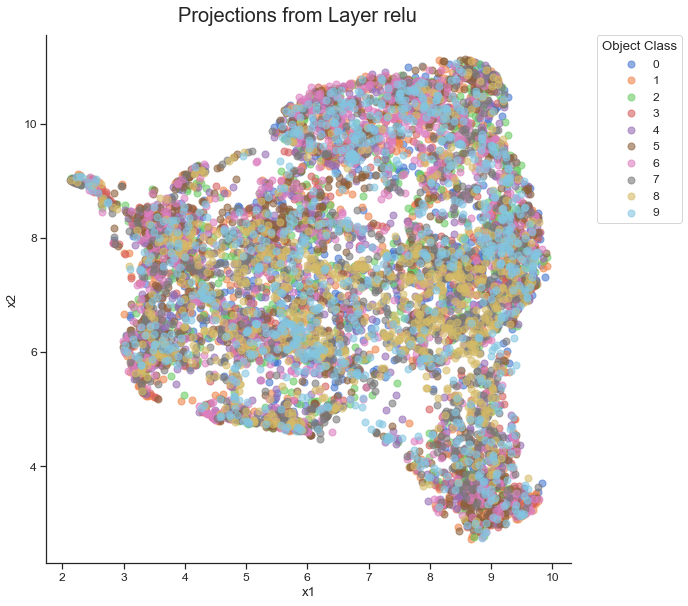

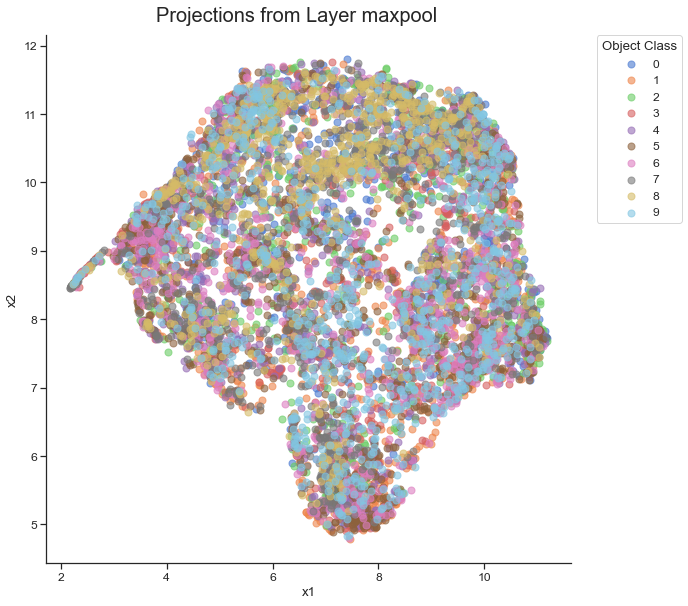

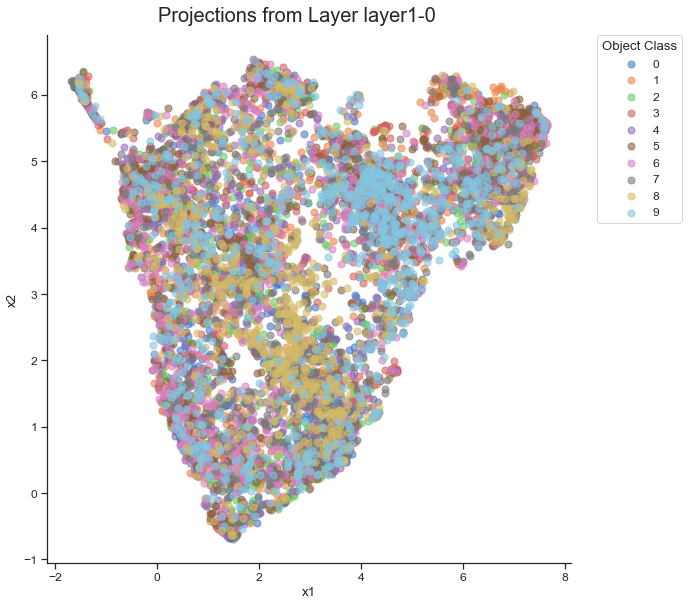

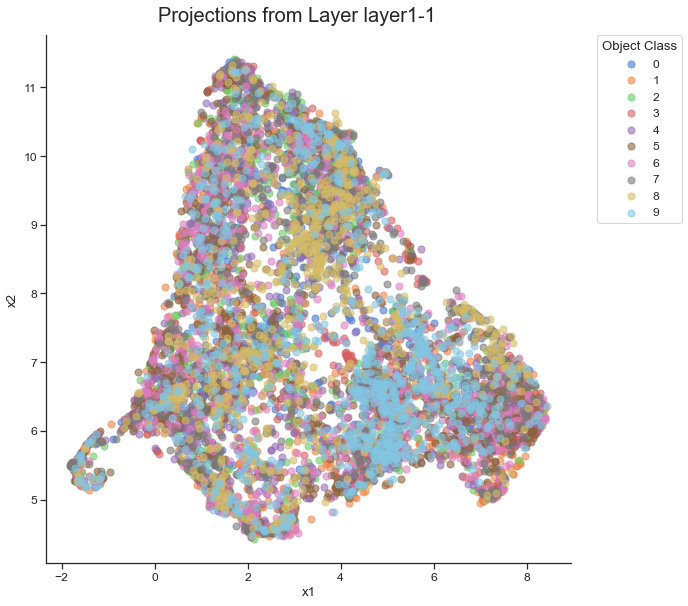

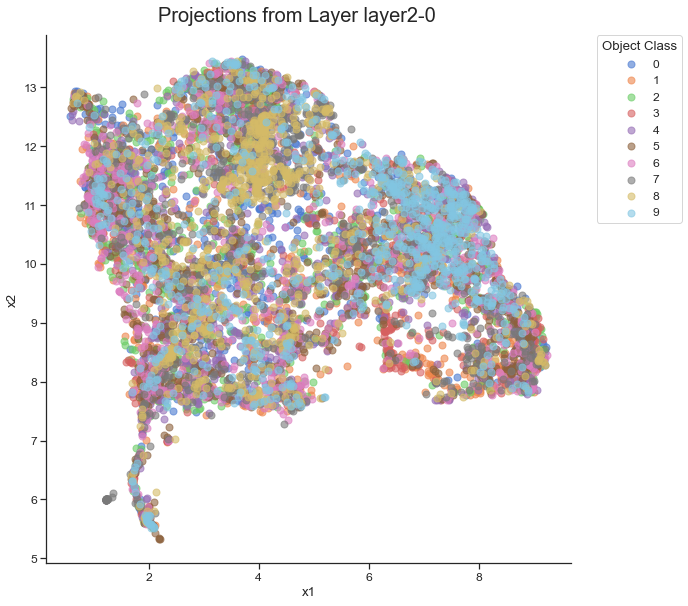

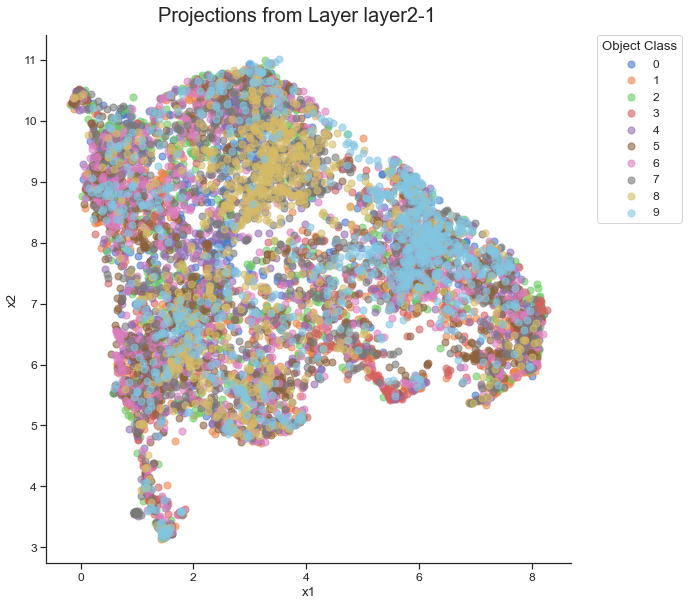

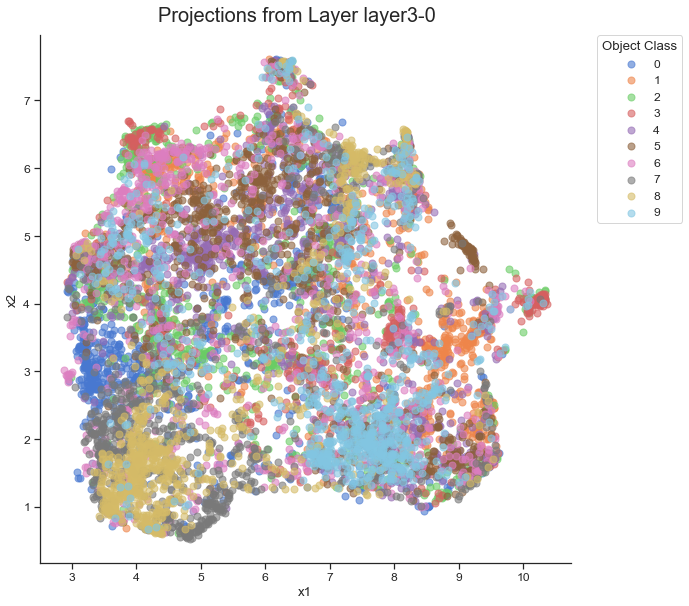

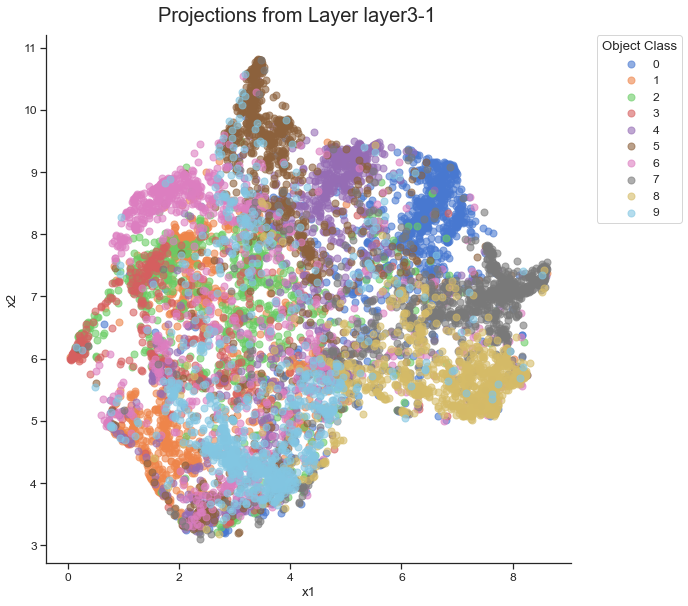

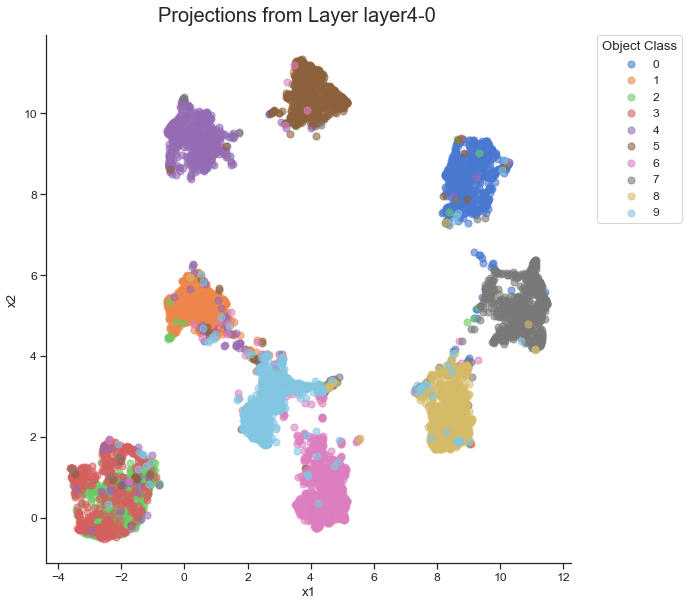

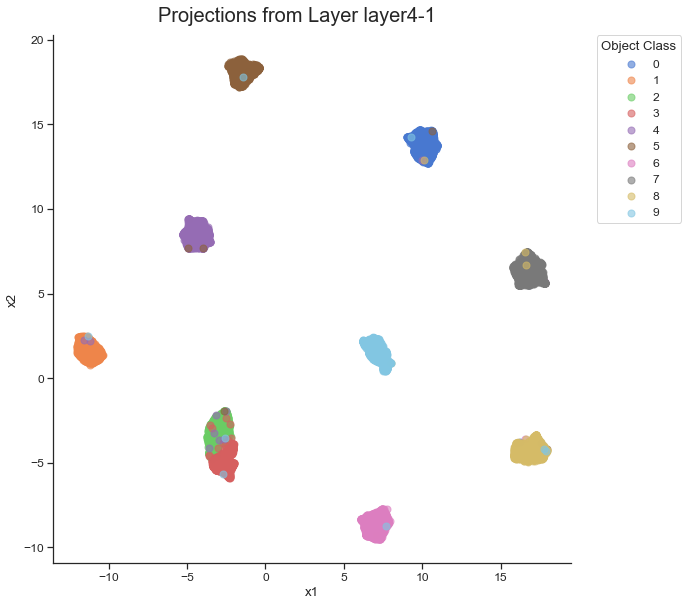

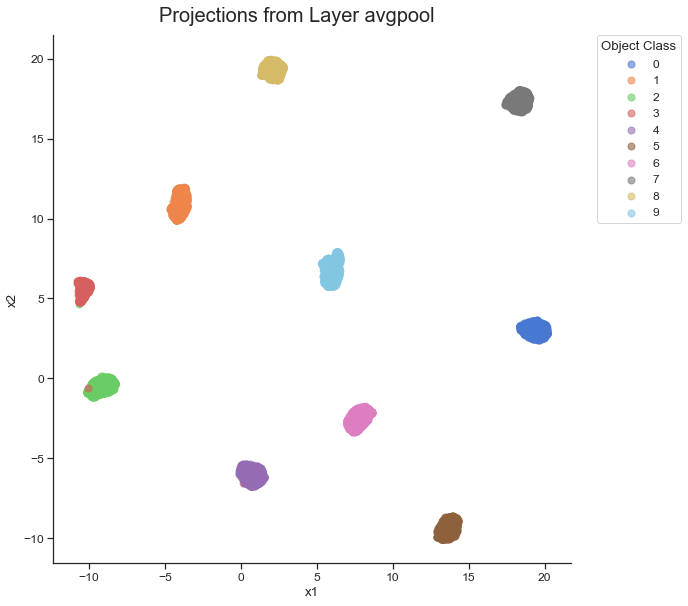

In [8]:
plot_projects(loaded_train_projections)

## Define Function for Getting the Calibration Projections

In [9]:
def get_projections(activation_vectors, ext_scaler, ext_reducer):    
    projections = {}
    projections['projections'] = {}
    projections['targets'] = None
    projections['scaler'] = {}
    projections['reducer'] = {}
    
    for layer_name in layer_names:
        print('## Computing Projections for Layer {}'.format(layer_name))
        
        # Normalize activations
        print('- external scaler is used')
        layer_activations = activation_vectors[layer_name]['activations']  
        layer_activations_norm = ext_scaler[layer_name].transform(layer_activations)
        
        print('- activations normalized: {}'.format(layer_activations_norm.shape))
        
        # Reduce activations
        print('- external reducer is used')
        proj_temp = layer_activations_norm
        for r in ext_reducer[layer_name]:
            proj_temp = r.transform(proj_temp)
        layer_projections = proj_temp
            
        print('- activations reduced: {}'.format(layer_projections.shape))
        
        # Save projections and reducer
        projections['projections'][layer_name] = layer_projections
        projections['reducer'][layer_name] = ext_reducer[layer_name]
        projections['scaler'][layer_name] = ext_scaler[layer_name]

        # Copy targets
        if activation_vectors[layer_name]['targets'] is not None:
            if projections['targets'] is not None:
                np.testing.assert_array_equal(projections['targets'], activation_vectors[layer_name]['targets'])
            else:
                projections['targets'] = activation_vectors[layer_name]['targets']

        print("done!")        
        print()

    return projections

## Getting Projections

In [10]:
calib_projections = get_projections(
    loaded_activations, 
    ext_scaler=loaded_train_projections['scaler'], 
    ext_reducer=loaded_train_projections['reducer']
)

## Computing Projections for Layer relu
- external scaler is used
- activations normalized: (750, 262144)
- external reducer is used
- activations reduced: (750, 2)
done!

## Computing Projections for Layer maxpool
- external scaler is used
- activations normalized: (750, 65536)
- external reducer is used
- activations reduced: (750, 2)
done!

## Computing Projections for Layer layer1-0
- external scaler is used
- activations normalized: (750, 65536)
- external reducer is used
- activations reduced: (750, 2)
done!

## Computing Projections for Layer layer1-1
- external scaler is used
- activations normalized: (750, 65536)
- external reducer is used
- activations reduced: (750, 2)
done!

## Computing Projections for Layer layer2-0
- external scaler is used
- activations normalized: (750, 32768)
- external reducer is used
- activations reduced: (750, 2)
done!

## Computing Projections for Layer layer2-1
- external scaler is used
- activations normalized: (750, 32768)
- external reducer i

In [11]:
print('targets: {}'.format(calib_projections['targets'].shape))
print()

for layer_name in layer_names:
    print('## layer {}'.format(layer_name))
    print('projections: {}'.format(calib_projections['projections'][layer_name].shape))
    print('scaler:      {}'.format(calib_projections['scaler'][layer_name]))
    print('reducer:     {}'.format(calib_projections['reducer'][layer_name]))
    print()

targets: (750,)

## layer relu
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer maxpool
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-0
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-1
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-0
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-1
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosin

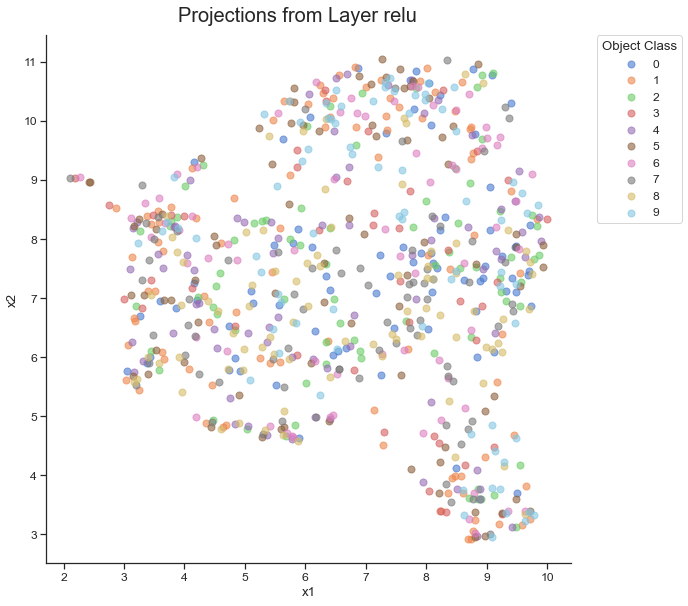

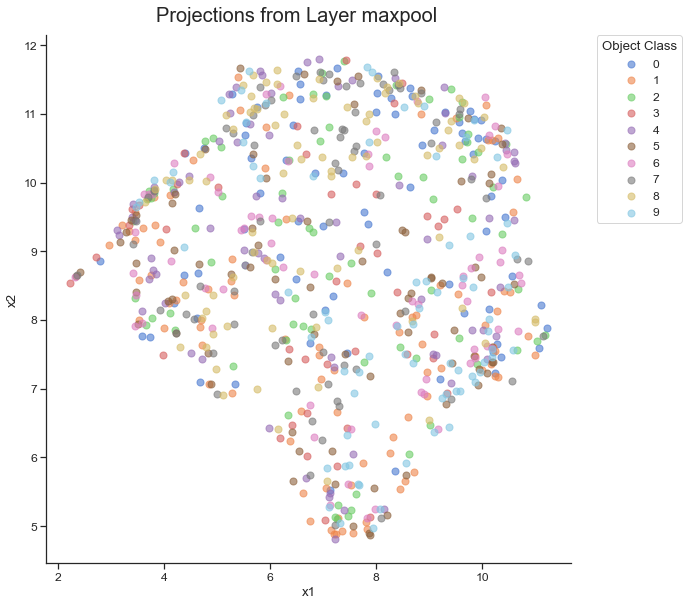

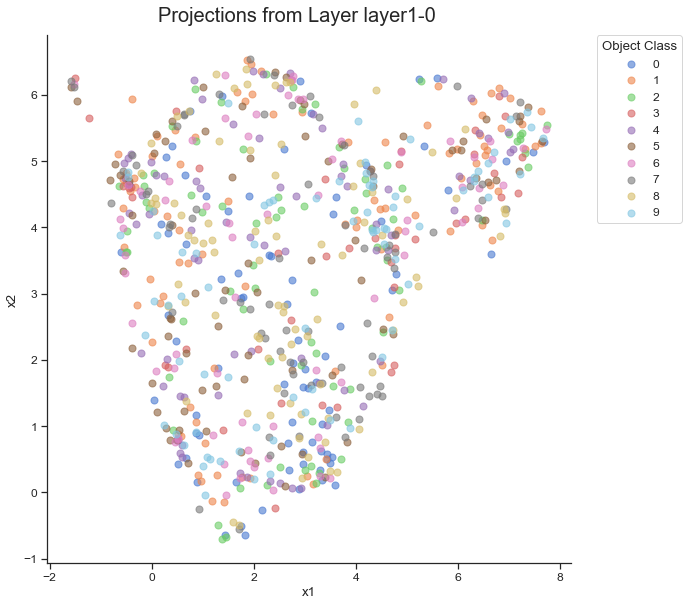

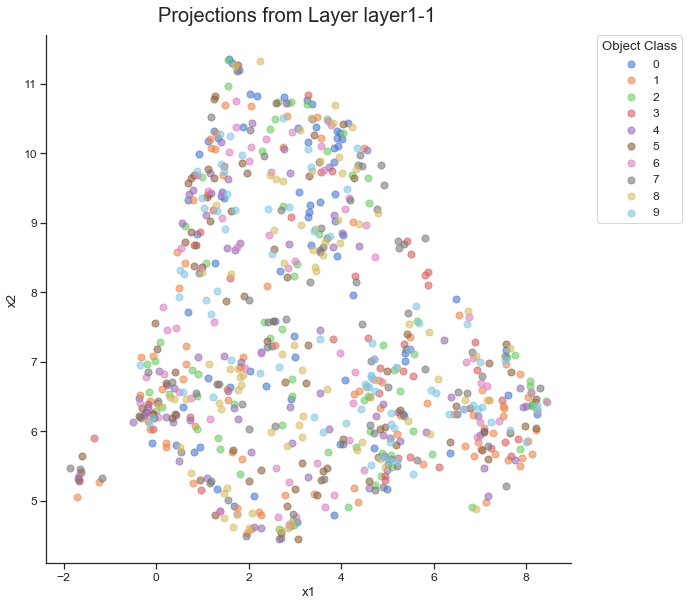

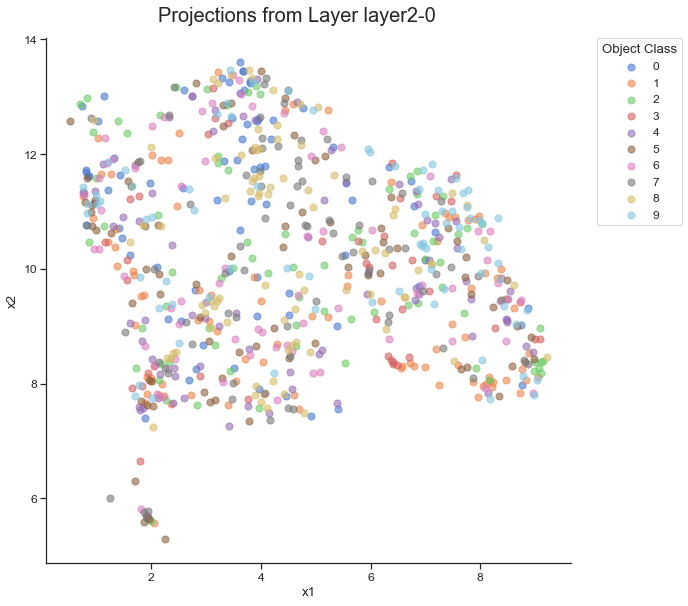

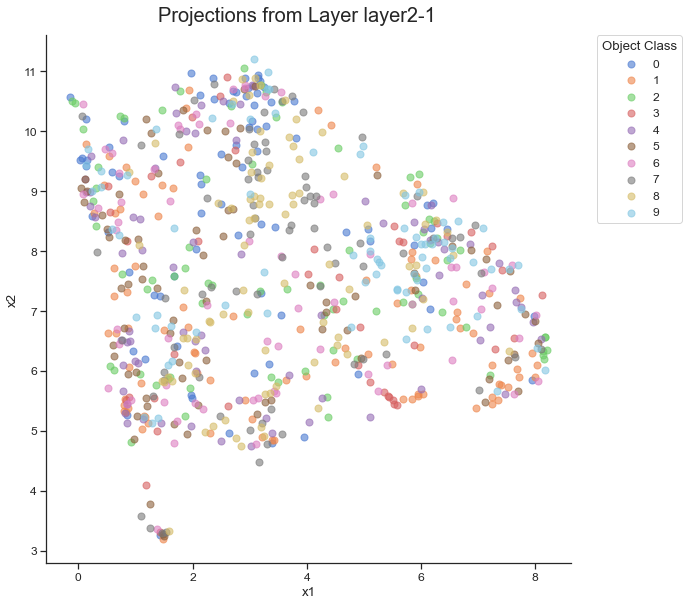

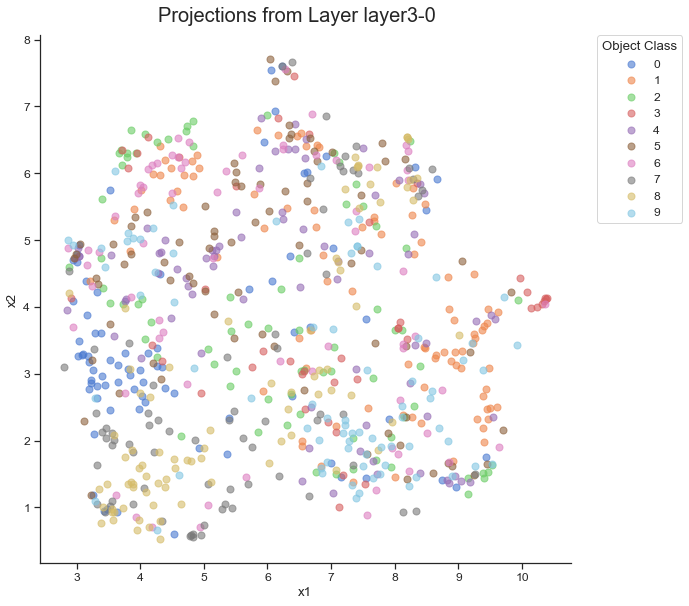

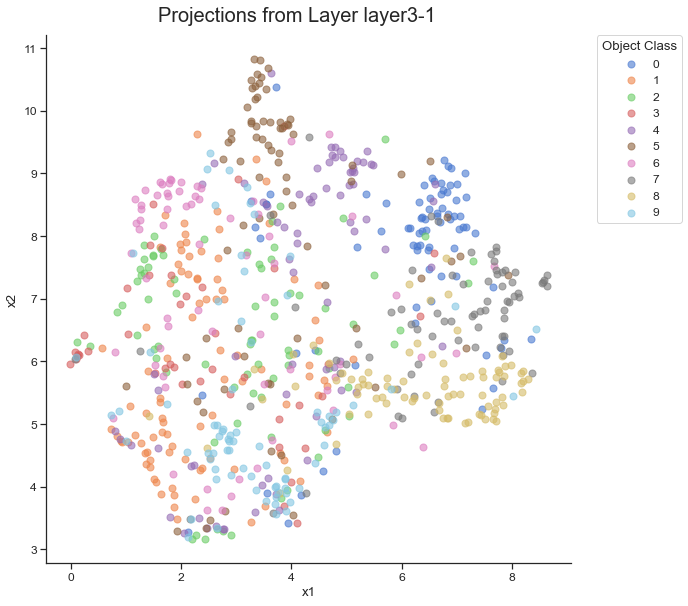

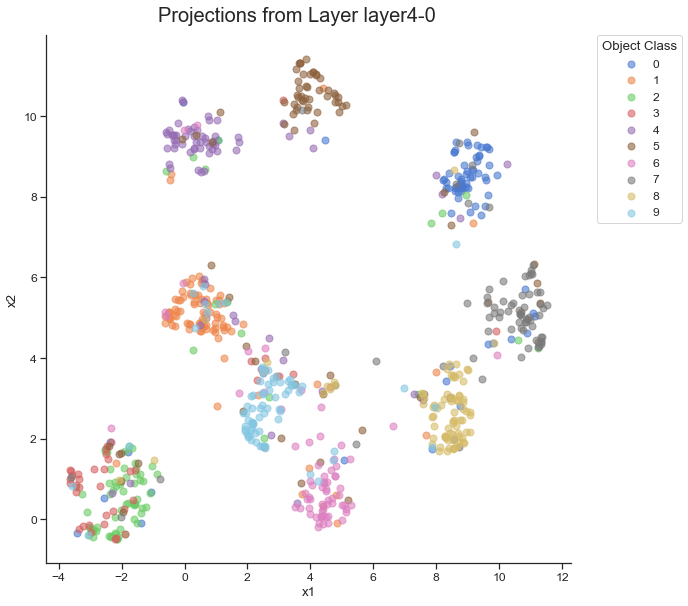

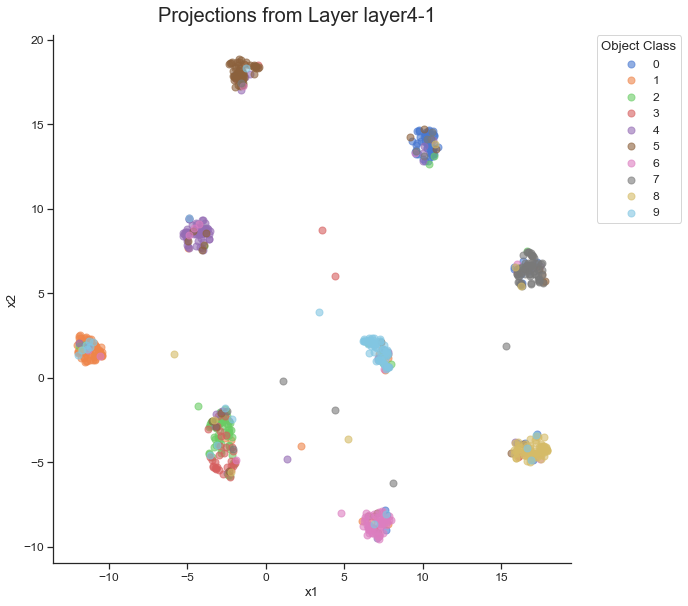

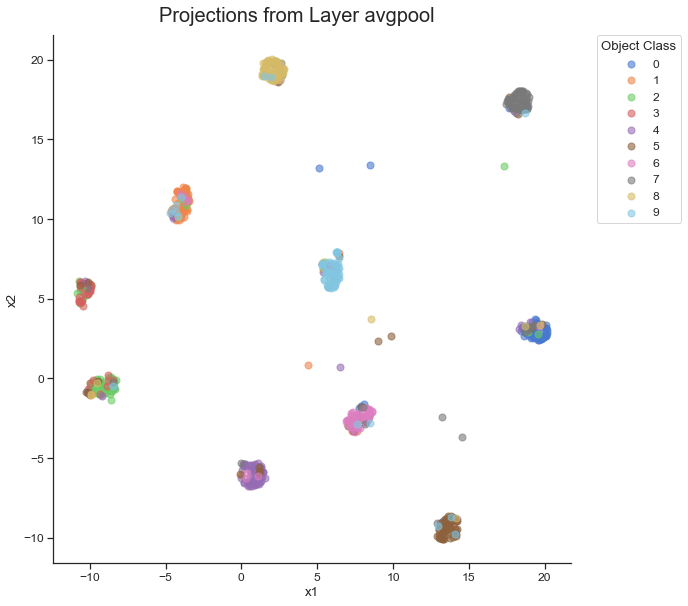

In [12]:
plot_projects(calib_projections)

## Store Projections

In [13]:
fname = str(projs_path) + '_{}_all.pkl'.format('calibset')
with open(fname, 'wb') as pickle_file:
    pickle.dump(calib_projections, pickle_file)

In [14]:
fname = str(projs_path) + '_{}_all.pkl'.format('calibset')
with open(fname, 'rb') as pickle_file:
    loaded_calib_projections = pickle.load(pickle_file)

In [15]:
print('targets: {}'.format(loaded_calib_projections['targets'].shape))
print()

for layer_name in layer_names:
    print('## layer {}'.format(layer_name))
    print('projections: {}'.format(loaded_calib_projections['projections'][layer_name].shape))
    print('scaler:      {}'.format(loaded_calib_projections['scaler'][layer_name]))
    print('reducer:     {}'.format(loaded_calib_projections['reducer'][layer_name]))
    print()

targets: (750,)

## layer relu
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer maxpool
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-0
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer1-1
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-0
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer layer2-1
projections: (750, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosin

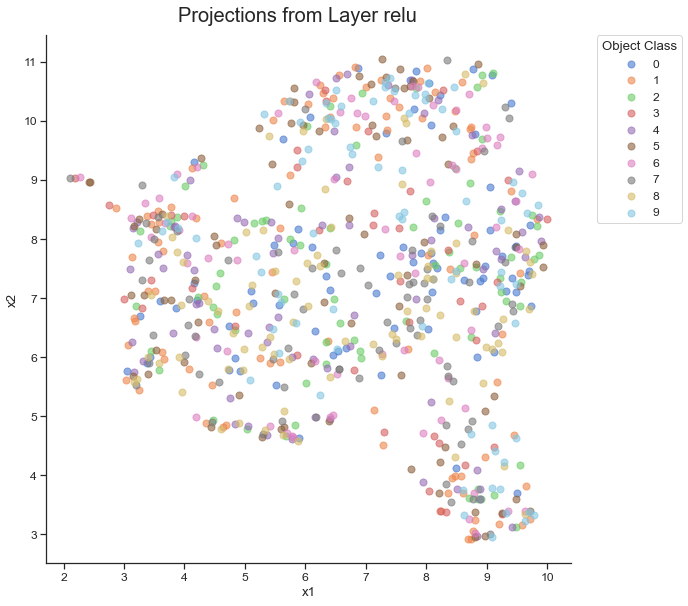

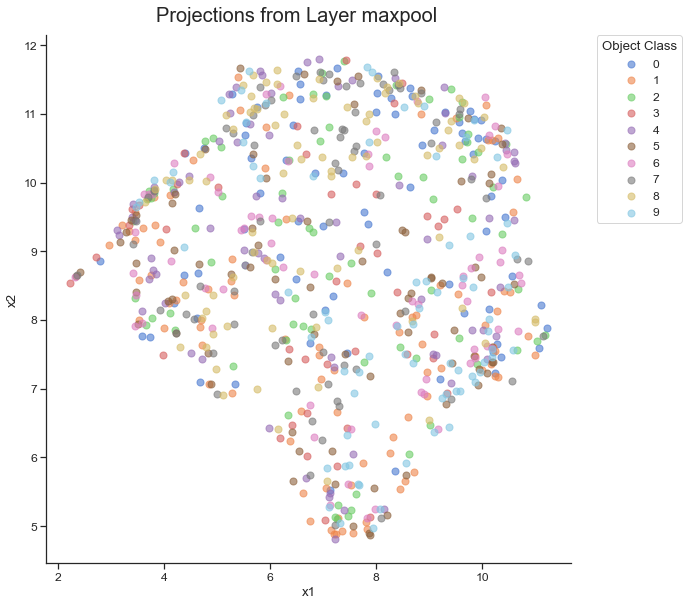

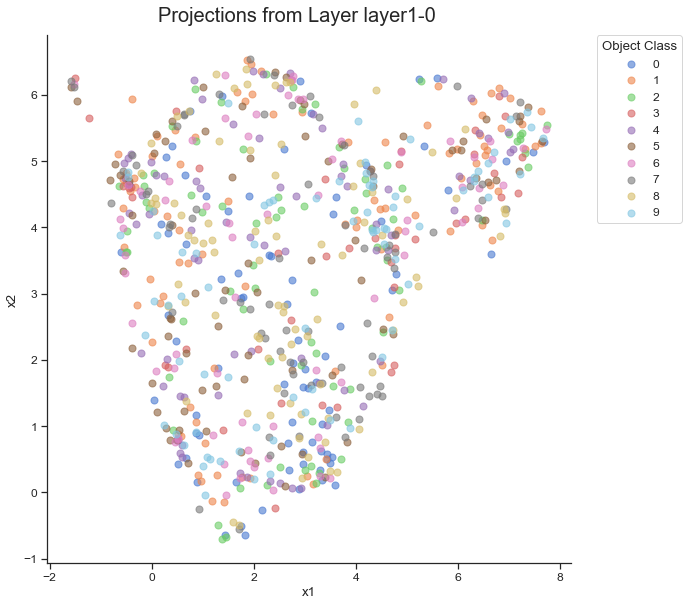

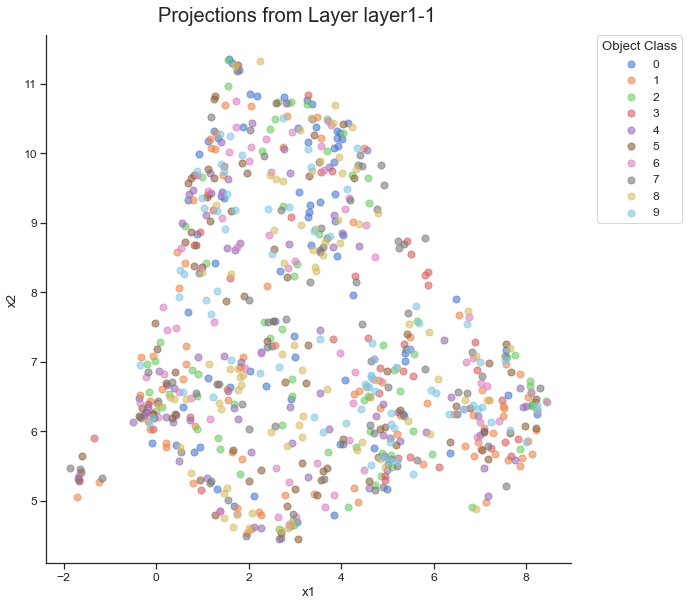

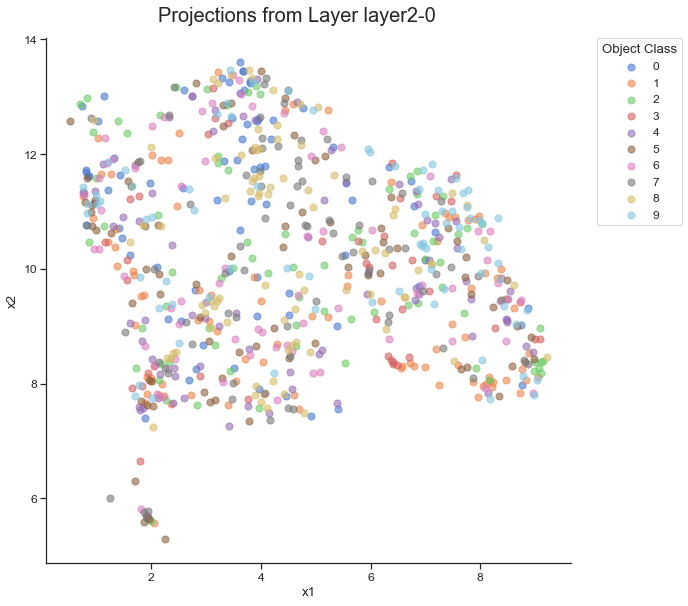

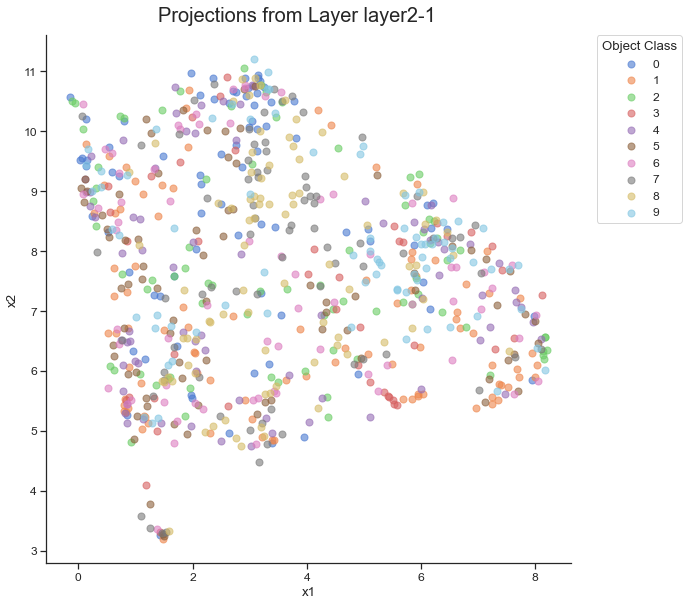

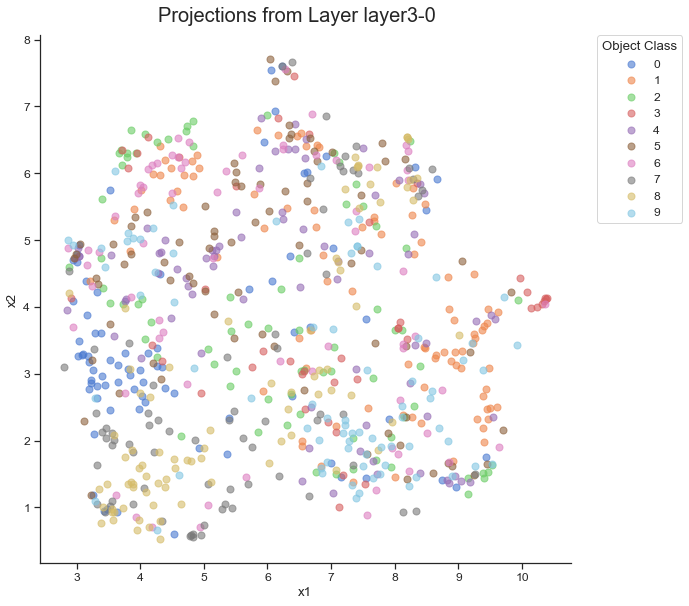

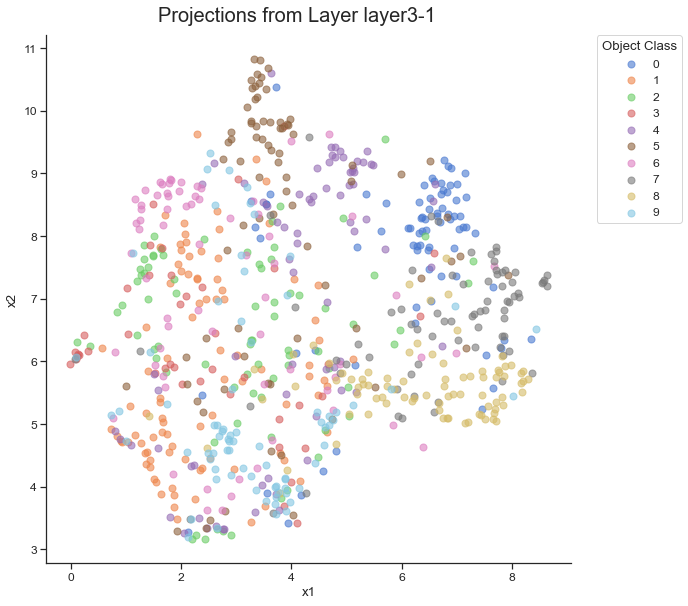

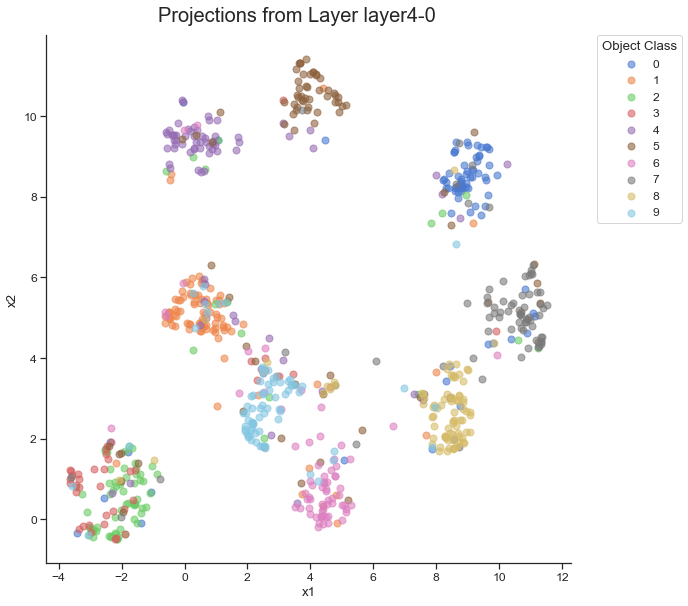

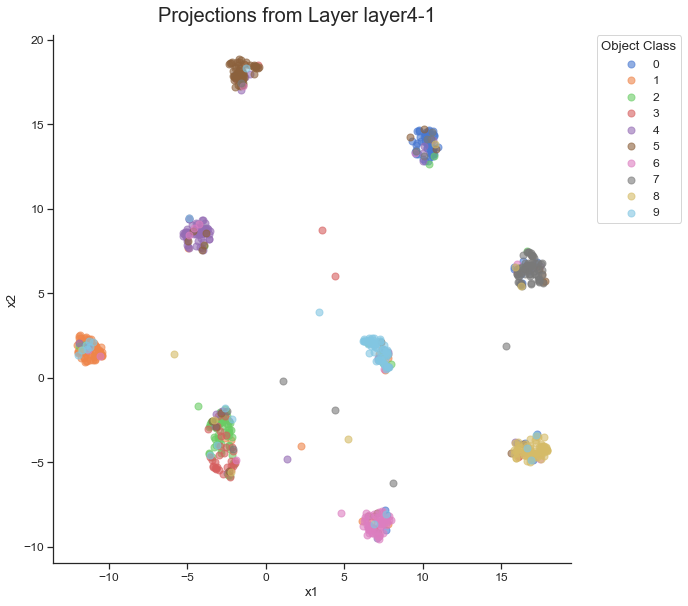

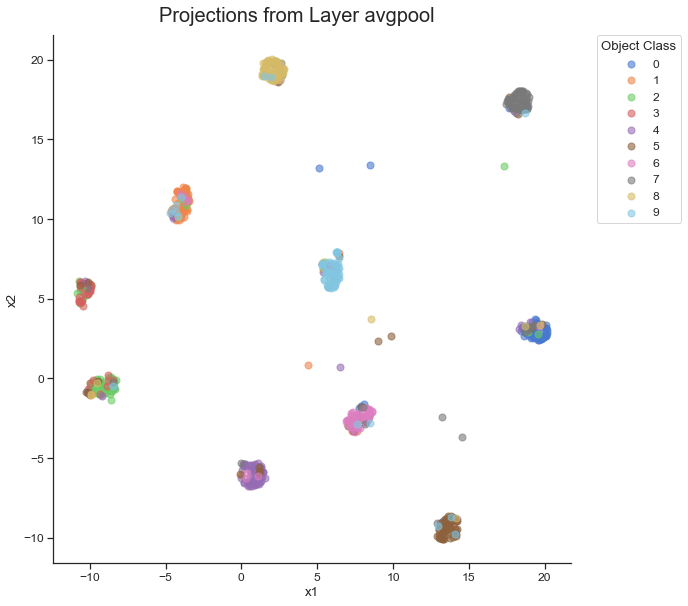

In [16]:
plot_projects(loaded_calib_projections)